#### From the IBL database, get data on weight and trial counts under different water regimes at CSHL
Anne Urai, CSHL, 2019

In [1]:
# PYTHON STARTS BY IMPORTING 'MODULES' AND 'PACKAGES' THAT WE'LL USE LATER

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# set a path where you want figures to be saved
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior

# set path for saving figures
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')


Connecting anneurai@datajoint.internationalbrainlab.org:3306


If your login to DataJoint was successful, you should see something like 

'Connecting youruser@datajoint.internationalbrainlab.org:3306'

In [2]:
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
# subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"' & 'subject_nickname="IBL_1"').proj( 'sex') * \
#     (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 6)



In [3]:
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)

# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')

# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"')
# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = subj * session_with_date * avg_weight_date * total_water_date

df = pd.DataFrame(b.fetch(as_dict=True))
df.tail(n=20)

,adlib,avg_weight,n_trials,session_date,session_start_time,sex,subject_nickname,subject_uuid,total_water,watertype
343,0,23.350000,692,2019-05-16,2019-05-16 13:44:02,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,1.785,Water 10% Sucrose
344,1,23.459999,671,2019-05-17,2019-05-17 12:58:38,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,1.638,Water 10% Sucrose; Water 2% Citric Acid
345,0,24.510000,714,2019-05-20,2019-05-20 12:28:39,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,1.695,Water 10% Sucrose
346,0,24.299999,693,2019-05-21,2019-05-21 13:02:12,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,1.752,Water 10% Sucrose
347,0,23.139999,1214,2019-05-23,2019-05-23 16:42:48,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,3.015,Water 10% Sucrose
348,0,24.830000,443,2019-05-24,2019-05-24 14:01:55,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,1.128,Water 10% Sucrose
349,0,24.370001,706,2019-05-28,2019-05-28 13:24:11,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,1.644,Water 10% Sucrose
350,0,24.520000,859,2019-05-29,2019-05-29 13:12:31,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2.166,Water 10% Sucrose
351,0,24.799999,1064,2019-05-30,2019-05-30 13:38:09,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2.604,Water 10% Sucrose
352,0,24.160000,1136,2019-06-03,2019-06-03 13:43:45,M,IBL_10,7c751b49-55a6-4eac-9bdb-367faf2a18ee,2.715,Water 10% Sucrose


In [8]:
# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['week_number']  = df['session_start_time'].dt.week
df['weekday_name'] = df['session_start_time'].dt.day_name()
df['weekday']      = df['session_start_time'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'O', 
                 17:'CC', 18:'CC', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))
sanitycheck

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


week_number  condition  session_date  weekday_name
12           C          2019-03-18    Monday                                        [Water 10% Sucrose]
                        2019-03-19    Tuesday                                       [Water 10% Sucrose]
                        2019-03-20    Wednesday                                     [Water 10% Sucrose]
                        2019-03-21    Thursday                                      [Water 10% Sucrose]
                        2019-03-22    Friday          [Water 10% Sucrose; Water 2% Citric Acid, Wate...
13           C          2019-03-25    Monday                                        [Water 10% Sucrose]
                        2019-03-26    Tuesday                                       [Water 10% Sucrose]
                        2019-03-27    Wednesday                                     [Water 10% Sucrose]
                        2019-03-28    Thursday         [Water 10% Sucrose, Hydrogel; Water 10% Sucrose]
             

In [46]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(60)

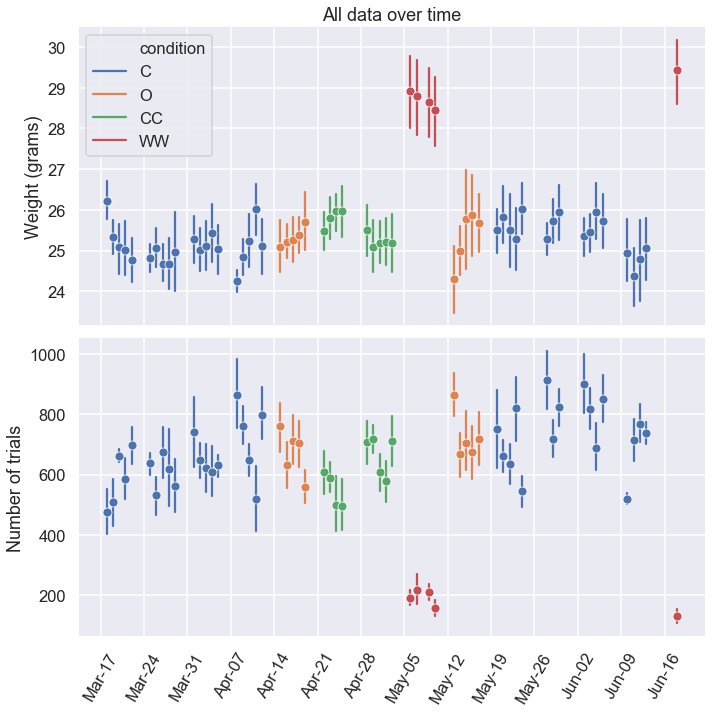

In [48]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(2,1, sharex=True, figsize=(10, 10))
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=0, data=df, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials", xlabel="")

# set grid to show Mondays
fix_date_axis(ax[1])
ax[0].set_title('All data over time')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_over_time.pdf"))

Now that we have our data, let's visualize it!

The plot above shows an example of using seaborn (https://seaborn.pydata.org/index.html), see the documentation for many other types of plots you can make. 

Try to make this plot a bit nicer, by doing the following:
1. move the legend to the right of the plot, or make it smaller so it doesn't obscure the datapoints. you can also rotate the 'tickmarks' (dates) on the x-axis to make them more readable.
- make an additional column with the day of the week

2. play with the arguments to 'lineplot' - see e.g. what happens when linewidth=1, or ci=95
3. instead of marking each day by its water condition _that day_, change the dataframe to label it with the condition of _that week_ (so that e.g. a week with only 10% sucrose water, but _preceded_ by a 2% CA weekend is different from a week with 10% sucrose water, but _preceded by a regular water weekend). this should then indicate the color
4. check in Alyx that all mice on a given day have the same 'condition'. Also make sure there are data logged for each day, including the weekend.
4. repeat the plot for individual mice (hint: seaborn's FacetGrid)


Of these, 3 and 4 are the most important: the rest is 

Once this looks good, try to create a new plot that ignores the date, and plots all datapoints (weight and nr of trials) from one condition (weekend + week water regime) in one overview - as on the SfN poster. You can use e.g. seaborn's catplot to make it look nice.

Other todo (for Anne):
1. indicate Mondays 


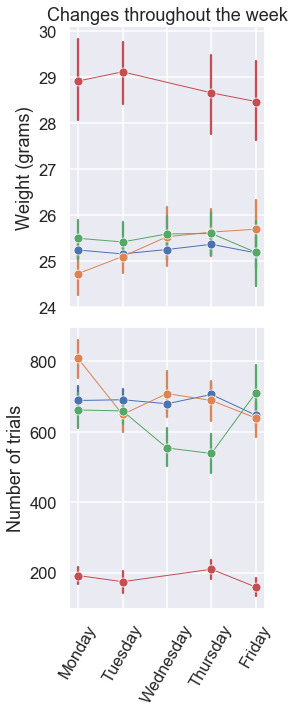

In [49]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(2,1, sharex=True, figsize=(4, 10))
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=1, data=df, ax=ax[0], legend=False)
ax[0].set(ylabel="Weight (grams)")
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[1], legend=False)
ax[1].set(ylabel="Number of trials", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="")
for item in ax[1].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Changes throughout the week')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_within_week.pdf"))

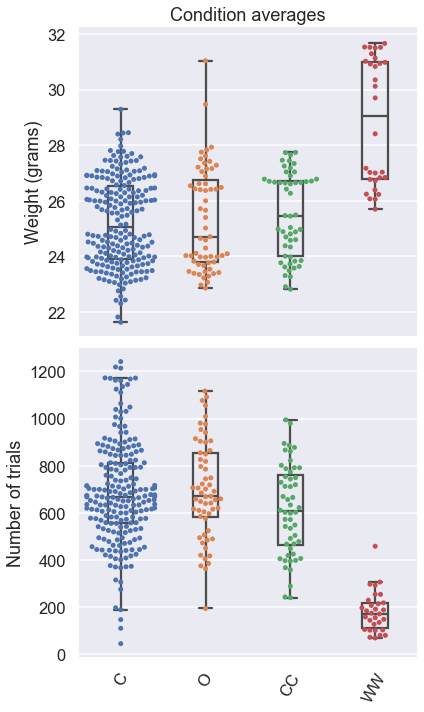

In [50]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(2,1, sharex=True, figsize=(6, 10))

sns.swarmplot(x="condition", y="avg_weight", hue="condition", data=df, ax=ax[0])
sns.boxplot(x="condition", y="avg_weight", data=df, fliersize=0, ax=ax[0], boxprops={'facecolor':'None'}, width=.3)
ax[0].set(ylabel="Weight (grams)", xlabel="")
ax[0].get_legend().remove()
sns.swarmplot(x="condition", y="n_trials", hue="condition", data=df, ax=ax[1])
sns.boxplot(x="condition", y="n_trials", data=df, fliersize=0, ax=ax[1], boxprops={'facecolor':'None'}, width=.3)

ax[1].set(ylabel="Number of trials", xlabel="")
ax[1].get_legend().remove()

for item in ax[1].get_xticklabels():
    item.set_rotation(60)
    
# set grid to show Mondays
ax[0].set_title('Condition averages')
f.tight_layout()
f.savefig(os.path.join(figpath, "CA_stats.pdf"))

In [51]:
# NOW DO STATS ON THE TRIAL COUNTS
import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("n_trials ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    n_trials  
No. Observations:     351        Method:                REML      
No. Groups:           6          Scale:                 32085.4574
Min. group size:      55         Likelihood:            -2308.8412
Max. group size:      60         Converged:             Yes       
Mean group size:      58.5                                        
------------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         686.249   46.351  14.806 0.000  595.403  777.095
condition[T.CC]   -78.072   27.766  -2.812 0.005 -132.493  -23.651
condition[T.O]      8.321   26.402   0.315 0.753  -43.427   60.068
condition[T.WW]  -504.782   34.965 -14.437 0.000 -573.313 -436.252
Group Var       11972.204   44.513                                



In [52]:
md = smf.mixedlm("avg_weight ~ condition", df, groups=df["subject_nickname"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: avg_weight
No. Observations:   351     Method:             REML      
No. Groups:         6       Scale:              0.6772    
Min. group size:    55      Likelihood:         -446.6533 
Max. group size:    60      Converged:          Yes       
Mean group size:    58.5                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       25.208    0.659 38.237 0.000 23.916 26.501
condition[T.CC]  0.349    0.128  2.735 0.006  0.099  0.599
condition[T.O]   0.168    0.121  1.381 0.167 -0.070  0.405
condition[T.WW]  3.641    0.161 22.669 0.000  3.326  3.956
Group Var        2.588    2.013                           

